# CHAPTER 8: Dimensionality Reduction

- Many Machine Learning problems involve thousands or even millions of features for
each training instance. 
- Not only does this make training extremely slow, it can also
make it much harder to find a good solution
- problem is often
referred to as the **curse of dimensionality.**
- Fortunately, in real-world problems, it is often possible to reduce the number of features
considerably, turning an intractable problem into a tractable one.

**Note:** 
- Reducing dimensionality does lose some information, so even though it will **speed up training**, it may also make your **system perform slighly worse.**
- It also makes your pipelines a bit more **complex and harder to maintain.**
- <span style='color:green'>So, you should first try to train your system with the original data before considering using dimensionality reduction if training is too slow.</span>
- <span style='color:green'>In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in **higher performance**. (but in general it wont, it will just speed up training</span>

- Apart from speeding up training, dimensionality reduction is also extremely useful for **data visualization (or DataViz)**
- Reducing the number of dimensions down to two
(or three) makes it possible to plot a condensed view of a high-dimensional training
set on a graph and often gain some important insights by visually detecting patterns,
such as clusters.

## 8.1 The Curse of Dimensionality

- if you pick two points randomly in a unit
square, the distance between these two points will be, on average, roughly 0.52.
- If you
pick two random points in a unit 3D cube, the average distance will be roughly 0.66
- But what about two points picked randomly in a 1,000,000-dimensional hypercube?
Well, the average distance, believe it or not, will be about 408.25 (roughly
1, 000, 000/6)!
- This is quite counterintuitive: how can two points be so far apart
when they both lie within the same unit hypercube?
- **This fact implies that high
dimensional
datasets are at risk of being very sparse: most training instances are
likely to be far away from each other.**
- Of course, this also means that a new instance
will likely be far away from any training instance, making predictions much less reliable
than in lower dimensions, since they will be based on much larger extrapolations.
- **In short, the more dimensions the training set has, the greater the risk of overfitting
it.**

## 8.2 Main Approaches for Dimensionality Reduction

Before we dive into specific dimensionality reduction algorithms, let’s take a look at
the two main approaches to reducing dimensionality: projection and Manifold
Learning.

### 8.2.3 Projection

- In most real-world problems, training instances are not spread out uniformly across
all dimensions. Many features are almost constant, while others are highly correlated
- As a result, all training instances actually lie within
(or close to) a much lower-dimensional **subspace** of the high-dimensional space.
- This
sounds very abstract, so let’s look at an example. In Figure you can see a 3D dataset
represented by the circles.

Note: all the codes below for the chart (ignore them for now)

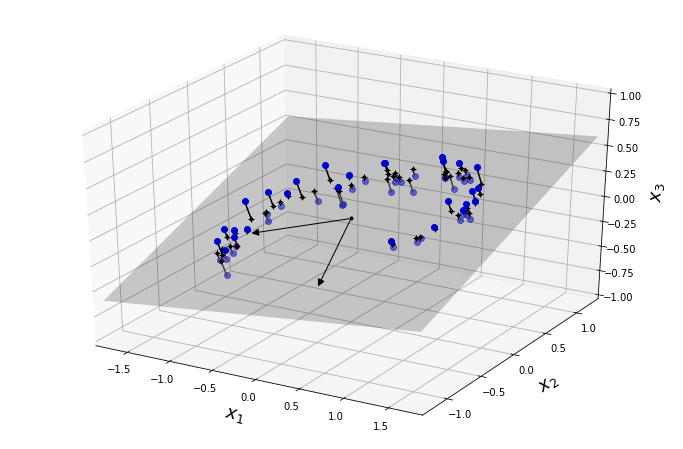

In [138]:
#Figure 8-2. A 3D dataset lying close to a 2D subspace

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d



np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
        
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)
        

    
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D
    
    
    
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)


X3D_inv = pca.inverse_transform(X2D)
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])







class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

        



        
# Express the plane as a function of x and y.
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])  



# Plot the 3D dataset, the plane and the projections on that plane.

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)


plt.show()

- Notice that all training instances lie close to a plane: this is a lower-dimensional (2D)
subspace of the high-dimensional (3D) space
- Now if we project every training
instance perpendicularly onto this subspace (as represented by the short lines connecting
the instances to the plane), we get the new 2D dataset shown in below figure.
- We have just reduced the dataset’s dimensionality from 3D to 2D.
- Note that
the axes correspond to new features **z1 and z2** (the coordinates of the projections on
the plane).

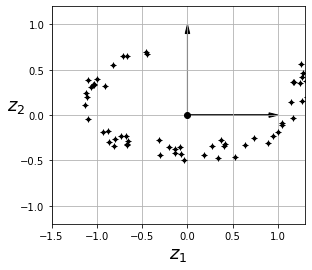

In [139]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

- However, projection is not always the best approach to dimensionality reduction
- In
many cases the subspace may twist and turn, such as in the famous **Swiss roll** toy dataset
represented in below figure.

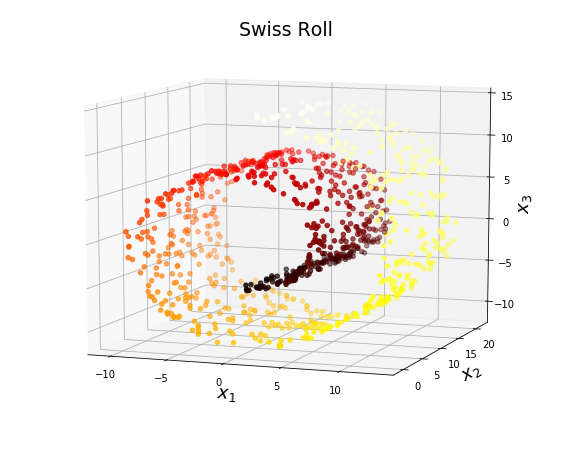

In [140]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Swiss Roll', fontsize=19)

plt.show()


- Simply projecting onto a plane (e.g., by dropping x3) would squash different layers of
the Swiss roll together, as shown on the left of figure
- However, what you really
want is to unroll the Swiss roll to obtain the 2D dataset on the right of figure.

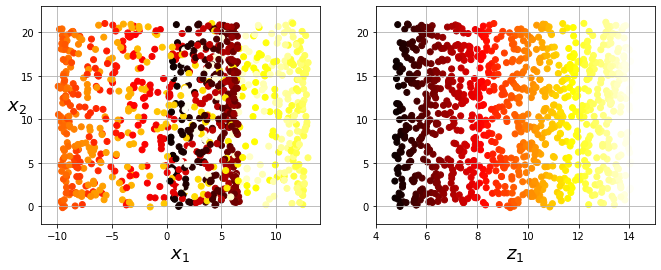

In [141]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

### 8.2.2 Manifold Learning

- The Swiss roll is an example of a 2D manifold.
 - Put simply, a 2D manifold is a 2D
shape that can be bent and twisted in a higher-dimensional space.
- **More generally, a
d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally
resembles a d-dimensional hyperplane.**
- In the case of the Swiss roll, d = 2 and n = 3: it
locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which
the training instances lie; this is called Manifold Learning. It relies on the manifold
assumption, also called the manifold hypothesis, which holds that most real-world
high-dimensional datasets lie close to a much lower-dimensional manifold. This
assumption is very often empirically observed.

Ex: Once again, think about the MNIST dataset: all handwritten digit images have some
similarities. They are made of connected lines, the borders are white, they are more
or less centered, and so on. If you randomly generated images, only a ridiculously
tiny fraction of them would look like handwritten digits. In other words, the degrees
of freedom available to you if you try to create a digit image are dramatically lower
than the degrees of freedom you would have if you were allowed to generate any
image you wanted. These constraints tend to squeeze the dataset into a lowerdimensional
manifold.

- **The manifold assumption is often accompanied by another implicit assumption: that
the task at hand (e.g., classification or regression) will be simpler if expressed in the
lower-dimensional space of the manifold.**
- **For example, in the third chart in below figure
the Swiss roll is split into two classes: in the 3D space, the decision boundary would be fairly complex, but in the 2D unrolled manifold space (4th chart), the decision boundary is a simple straight line.**
- **However, this assumption does not always hold. For example, in the first chart in below 
Figure, the decision boundary is located at x1 = 5. This decision boundary looks
very simple in the original 3D space (a vertical plane), but it looks more complex in
the unrolled manifold (a collection of four independent line segments).(second chart)**

<span style='color:red'>**In short, if you reduce the dimensionality of your training set before training a
model, it will usually speed up training, but it may not always lead to a better or simpler
solution; it all depends on the dataset.**</span>

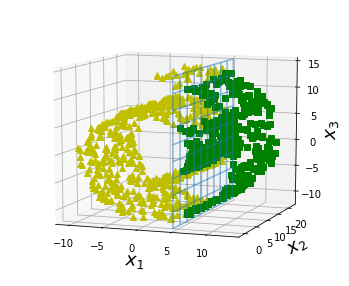

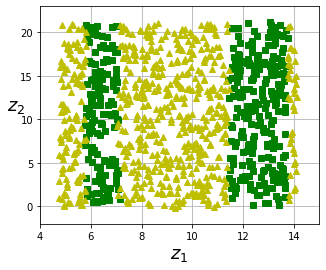

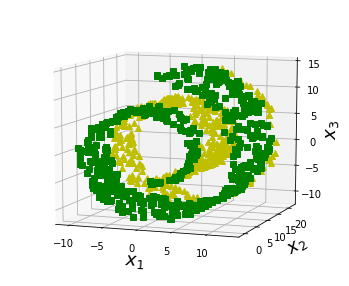

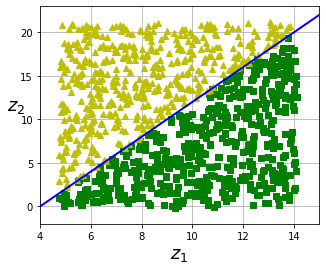

In [142]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)



fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])



fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## 8.3 Principal Component Analysis (PCA)

PCA is by far the **most popular** dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

## 8.3.1 Preserving the Variance

- Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane.
- For example, a simple 2D dataset is represented in the below figure, along with three different axes (i.e one dimensional hyperplanes)
- On the right is the result of the projection of the dataset onto each of these axes.
- As you can see, the projection onto the solid line preserves the **maximum variance**, while the projection onto the dotted line preserves very little variance, and the projection onto the dashed line preserves an intermediate amount of variance.

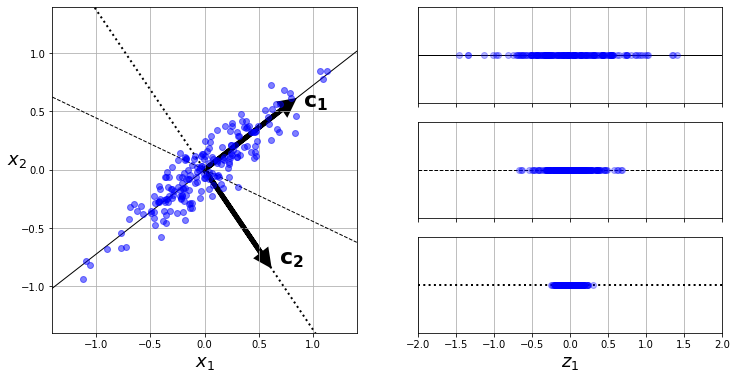

In [143]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

- It seems reasonable to select the axis that preserves the **maximum amount of variance**, as it will most likely **lose less information** than the other projections.
- Another way to justify this choice is that it is the axis that **minimizes the mean squared distance** between the orginal dataset and its projection onto that axis.
- **This is the rather simple idea behind <span style='color:red'> PCA.</span>**

**<span style='color:red'> Notice: that the data is centered to the origin before finding c1 and c2.</span>**

## 8.3.2 Principal Components

- PCA identifies the axis that accounts for the largest amount of variance in the training
set.
- It also finds a second axis, orthogonal to the
first one, that accounts for the largest amount of remaining variance.
- If it were a higher-dimensional dataset,
PCA would also find a third axis, orthogonal to both previous axes, and a fourth,
a fifth, and so on—as many axes as the number of dimensions in the dataset.

**The unit vector that defines the ith axis is called the ith principal component (PC).**
- In above figure c1 is 1.PC, and c2 is 2.PC

So how can you find the principal components of a training set? Luckily, there is a
standard matrix factorization technique called Singular Value Decomposition (SVD)
that can decompose the training set matrix X into the matrix multiplication of three
matrices, where V contains all the principal components that we are looking
for, as shown in equation!



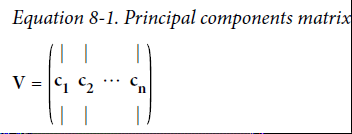

In [144]:
# Build 3D dataset

np.random.seed(4)
m = 60
w1, w1 = 0.1, 0.3
noise = 0.1


angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m,3))

X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [145]:
#ex
X[0:5]

array([[-1.01570027, -0.55091331, -0.46446632],
       [-0.00771675,  0.59958572,  0.0335342 ],
       [-0.95317135, -0.46453691, -0.43983715],
       [-0.92012304,  0.21009593, -0.1622008 ],
       [-0.76309739,  0.158261  ,  0.03890549]])

- The following Python code uses Numpy's **svd()** function to obtain all the principal components of the training set, then extract the first two PCs.

In [146]:
# subtract the mean of the column from each value in the column
X_centered = X - X.mean(axis=0)

# unpack the results (look at the above formula)
U, s, Vt = np.linalg.svd(X_centered)

# take the transpose of the Vt to obtain V. 
# Then get the columns as c1 and c2 (look at equation 8.2)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

- PCA assumes that the dataset is **centered** around the origin.
- As we will see, Scikit-Learn's PCA classes take care of centering the data for you.
- However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, **dont forget to center the data first.**

- The multiplication of U, s, and Vt should be equal to X_centered. (SVD solution)
- Lets check this equation
- Note: **<span style='color:red'>np.allclose() returns true if both matrices are same element wise</span>**


In [147]:
s

array([7.12236794, 2.77830309, 0.75546068])

In [148]:
np.diag(s)

array([[7.12236794, 0.        , 0.        ],
       [0.        , 2.77830309, 0.        ],
       [0.        , 0.        , 0.75546068]])

In [149]:
m, n = X.shape

# prepare the S as it can be multiplied by U
S = np.zeros(X_centered.shape)
# put the values of diagonal s
S[:n, :n] = np.diag(s)

#show the first 10 line, others are all 0s.
S[:10]

array([[7.12236794, 0.        , 0.        ],
       [0.        , 2.77830309, 0.        ],
       [0.        , 0.        , 0.75546068],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [150]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

- So the svd calculation was correct/proved.

## 8.3.3 Projecting Down to d Dimensions

- Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components.
- Selecting this hyperplane ensures that the projection will preserve as much as variance as possible. 
- For example, in Figure 8-2 the 3D dataset is projected down to the 2D plane defined by the first two principal components,preserving a large part of the dataset’s variance.
 - As a result, the 2D projection looks very much like the original 3D dataset.

- To project the training set onto the hyperplane, you can simply compute the matrix
multiplication of the training set matrix **X** by the matrix **Wd**, defined as the matrix
containing the first d principal components (i.e., the matrix composed of the first **d**
columns of V),

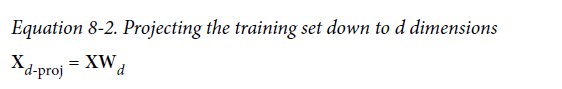

- The following code projects the training set onto the plane defined by the first two principal components.

In [151]:
# first two vector of matrix V is: W2 -> defined as the matrix containing the first two principal components
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

- There you have it! You now know how to reduce the dimensionality of any dataset down to any number of dimensions, while preserving as much variance as possible.

## 8.3.4 Using Scikit-Learn

- Scikit-Learns **PCA** clas implements PCA using **SVD (singular value decomposition)** decomposition just like we did in previous sections manually.
- The following code applies PCA to reduce the dimensionality of the dataset down to 2 dimensions.
- Note: it automatically takes care of centering the data.

In [152]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

- After fitting the PCA transformer to the dataset, you can access the principal components using the **components_** variable
- It contains the PCs as horizontal vectors, so, for example the first principal component is equal to pca.components_.T.[:,0]

In [153]:
# the first principal component
pca.components_.T[:,0]

array([-0.88902585, -0.28731195, -0.35648967])

**Compare the ScikitLearns' PCA with the manual SVD that you have performed**

In [154]:
X2D[:5]

array([[ 1.33560771,  0.40933094],
       [-0.06859985, -0.35881098],
       [ 1.24642087,  0.34920317],
       [ 0.9242355 , -0.30471924],
       [ 0.72783612, -0.23736509]])

In [155]:
X2D_using_svd[:5]

array([[-1.33560771, -0.40933094],
       [ 0.06859985,  0.35881098],
       [-1.24642087, -0.34920317],
       [-0.9242355 ,  0.30471924],
       [-0.72783612,  0.23736509]])

- **Notice that** running PCA multiple times on slightly different datasets may result in different results.
- In general the only difference is that some axes may be flipped.
- In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [156]:
# they are same if you multiply with -1.
np.allclose(X2D, -X2D_using_svd)

True

## 8.3.4 Explained Variance Ratio

- Explained variance ratio of each principal component available via the **explained_variance_ratio_** variable.
- It indicates the proportion of the dataset's variance that lies along the axis of each principal component.
- For example, let’s look at the explained variance ratios of the first two components
of the 3D dataset represented in Figure 8-2

In [157]:
pca.explained_variance_ratio_

array([0.85953921, 0.13079048])

- 84.2% of the dataset's variance lies along the first axis, and 14.6% lies along the second axis.
- The remaining 1.2% variance lies along the third axis, so it is reasonable to assume that it probably carries little information.

## 8.3.5 Choosing the Right Number of Dimensions

- Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the **variance** (ex: 95%).
- Unless, of course, you are reducing dimensionality for data visualization -- in that case you will generally want to reduce the dimensionality down to 2 or 3.

- The following code computes PCA without reducing dimensionality, then computes
the minimum number of dimensions required to preserve 95% of the training set’s
variance:

In [158]:
# prepare data

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [159]:
pca = PCA()
pca.fit(X_train)

# this is the cumulative sum of the explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)

# find the dimension that provides 95% variance
d = np.argmax(cumsum >= 0.95) + 1
d

154

- So, the dimension that provides 95% variance has been found.
- We can now run PCA with n_components=154
- However, there is a much
better option: instead of specifying the number of principal components you want to
preserve, you can set **n_components to be a float between 0.0 and 1.0**, indicating the
ratio of variance you wish to preserve

In [160]:
# provide a float parameter that indicates desired explained variance instead of dimensionality
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

- Both solutions are giving the same results d=154 for 95% explained variance
- Yet another option is to plot the explained variance as a function of the number of
dimensions (simply plot cumsum)
- There will usually be an elbow in the
curve, where the explained variance stops growing fast.
- You can think of this as the
intrinsic dimensionality of the dataset.
- In this case, you an see that reducing the dimensionality down to about 100 dimensions would not lose too much explained variance.

Text(70, 0.7, 'Elbow')

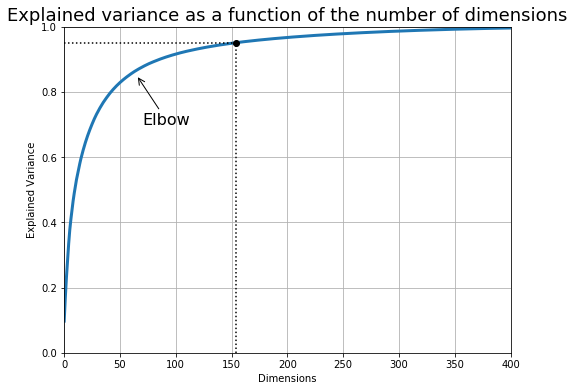

In [161]:
plt.figure(figsize=(8,6))
plt.grid(True)

plt.plot(cumsum, linewidth=3)
plt.axis([0,400,0,1])
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')


# plot the vertical dashed line
plt.plot([d,d],[0, 0.95], 'k:')
# plot the horizontal dashed line
plt.plot([0,d],[0.95, 0.95], 'k:')
# plot the point
plt.plot(d,0.95, 'ko')

plt.title('Explained variance as a function of the number of dimensions', fontsize=18)
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)


## 8.3.6 PCA for Compression

- Obviously after dimensionality reduction, the training set takes up much **less space**
- For example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features (154 found in previous section), instead of the original 784 features.
- So while most of the variance is preserved, the dataset is now less than 20% of its original size!
- This is a reasonable **compression ratio**, and you can see how this can **speed up** a classification algorithm (such as an SVM classifier) tremendously.

- It is also possible to <span style='color:red'>**decompress**</span> the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection.
- **Of course this won’t give
you back the original data, since the projection lost a bit of information (within the
5% variance that was dropped), but it will likely be quite close to the original data.**
- The mean squared distance between the original data and the reconstructed data
(compressed and then decompressed) is called the <span style='color:red'>**reconstruction error.**</span>

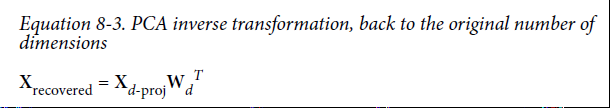

- For example,
the following code compresses the MNIST dataset down to 154 dimensions, then uses
the **inverse_transform()** method to decompress it back to 784 dimensions.

In [162]:
# note: X_train is from MNIST dataset

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

# for later usage
X_reduced_pca = X_reduced

Text(0.5, 1.0, 'Compressed')

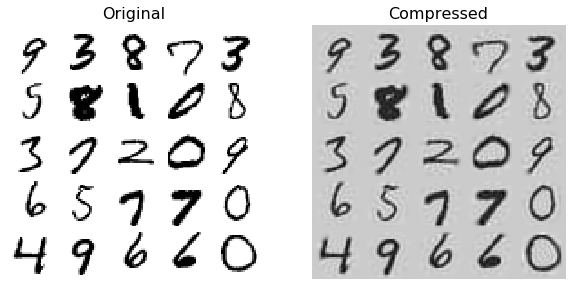

In [163]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
    
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

- Figure shows a few digits from the original training set, and the corresponding digits after compression and decompression.
- You can see that there is a slight image quality loss, but the digits are still mostly intact.

## 8.3.7 Randommized PCA

- If you set the **svd_solver** hyperparameter to **"randomized"**, Scikit-Learn uses a stochastic algorithm called **Randomized PCA** that quickly fits an approximation of the first d principal components.
- Its computational complexity is O(m × d2) + O(d3),
instead of O(m × n2) + O(n3) for the full SVD approach, so it is dramatically faster
than full SVD when d is much smaller than n:

In [164]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

- By default, svd_solver is actually set to **"auto"**: Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach.
- If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to **"full"**.

## 8.3.8 Incremental PCA

- One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run.
- Fortunately, **Incremental PCA (IPCA)** algorithms have been developed: you can split the training set into **mini-batches** and feed an IPCA algortihm one mini-batch at a time.
- This is useful for large training sets, and also to apply PCA online (i.e, on the fly, as new instances arrive)

- The following code splits the MNIST dataset into 100 mini-batches (using NumPy's array_split() function) and feeds them to Scikit-Learn's **IncrementalPCA** class to reduce the dimensionality of the MNIST dataset down to 154 dimensions.
- Note that you must call the **partial_fit()** method with each mini-batch rather than the **fit()** method with the whole training set.

In [165]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

# to keep the value for future use
X_reduced_inc_pca = X_reduced
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

-------------------------

- Alternatively, you can use NumPy’s **memmap class**, which allows you to manipulate a
large array stored in a binary file on disk as if it were entirely in memory; the class
loads only the data it needs in memory, when it needs it.
- Since the IncrementalPCA
class uses only a small part of the array at any given time, the memory usage remains
under control.
- This makes it possible to call the usual **fit()** method, as you can see
in the following code:

In [169]:
# Let's create the memmap() structure and copy the MNIST data into it. This would typically be done by a first program:

filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

OSError: [Errno 22] Invalid argument: 'my_mnist.data'

In [ ]:
# Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.
del X_mm

In [ ]:
# Next, another program would load the data and use it for training:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

-------------------------

**COMPARE** the results of transforming MNIST using **regular PCA** and **incremental PCA**
- as you see the means are equal

In [171]:
np.allclose(pca.mean_, inc_pca.mean_)

True

- But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [172]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

## Time Complexity

- Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [173]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.2 seconds
    IncrementalPCA: 9.1 seconds
    PCA: 1.1 seconds
n_components = 10
    PCA: 1.3 seconds
    IncrementalPCA: 10.0 seconds
    PCA: 1.3 seconds
n_components = 154
    PCA: 3.8 seconds
    IncrementalPCA: 12.7 seconds
    PCA: 3.8 seconds


- Now let's compare PCA and Randomized PCA for datasets of different sizes **(number of instances)**:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

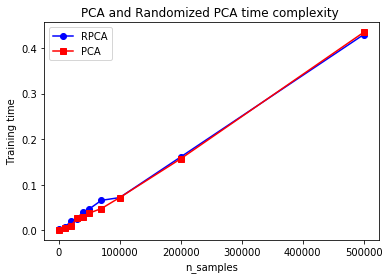

In [184]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

- And now let's compare their performance on datasets of 2,000 instances with various **numbers of features**:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

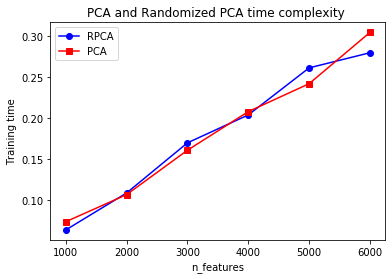

In [187]:

times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## 8.4 Kernel PCA

- In Chapter 5:Support Vector Machines we discussed the kernel trick, mathematical technique that implicitly
maps instances into a very high-dimensional space (called the feature space), enabling
nonlinear classification and regression with Support Vector Machines.
 - Recall that a linear decision boundary in the high-dimensional feature space corresponds to a **complex nonlinear decision boundary** in the original space.
- It turns out that the same trick can be applied to PCA, making it possible to perform
complex nonlinear projections for dimensionality reduction.
- This is called **KernelPCA (kPCA)**.
- It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

- For example, the following code uses Scikit-Learn’s KernelPCA class to perform kPCA
with an RBF kernel (see Chapter 5 for more details about the RBF kernel and the
other kernels):

In [194]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

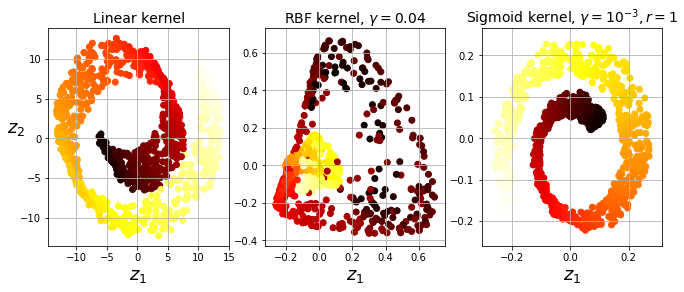

In [195]:
# graph comparing different kernels
# Swiss roll reduced to 2D using kPCA with various kernels

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))

for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

## 8.4.1 Selecting a Kernel and Tuning Hyperparameters

- As kPCA is an unsupervised learning algorithm, there is no obvious performance
measure to help you select the best kernel and hyperparameter values.
- However,
dimensionality reduction is often a preparation step for a supervised learning task
(e.g., classification), so you can simply use grid search to select the kernel and hyperparameters
that lead to the best performance on that task.

- For example, the following
code creates a two-step pipeline, first reducing dimensionality to two dimensions
using kPCA, then applying Logistic Regression for classification.
- Then it uses Grid
SearchCV to find the best kernel and gamma value for kPCA in order to get the best
classification accuracy at the end of the pipeline:

In [196]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [198]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

- The best kernel and gamma values are found.

- Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters
that yield the **lowest reconstruction error.**
- However, reconstruction is not
as easy as with linear PCA.
- Figure 8-11 shows the original Swiss roll 3D
dataset (top left), and the resulting 2D dataset after kPCA is applied using an RBF
kernel (top right).
- Thanks to the kernel trick, this is mathematically equivalent to
mapping the training set to an infinite-dimensional feature space (bottom right)
using the feature map φ, then projecting the transformed training set down to 2D
using linear PCA.
- Notice that if we could invert the linear PCA step for a given
instance in the reduced space, the reconstructed point would lie in feature space, not
in the original space (e.g., like the one represented by an x in the diagram).
    - Çünkü Reduced space'e direkt olarak 3D space den ulaşılmadı. Önce Feature Space e gidildi sonra, oradan dimensionality reduction yapılarak Reduced Space e gelindi. Yani Reduced Space den reconstruction yaptığında data point 3D space de değil, feature space'de oluşuyor.
- Since the
feature space is infinite-dimensional, we cannot compute the reconstructed point,
and therefore we cannot compute the true reconstruction error.
- Fortunately, it is possible
to find a point in the original space that would map close to the reconstructed
point.
- This is called the **reconstruction pre-image.**
- Once you have this pre-image, you
can measure its squared distance to the original instance. You can then select the kernel
and hyperparameters that minimize this reconstruction pre-image error.

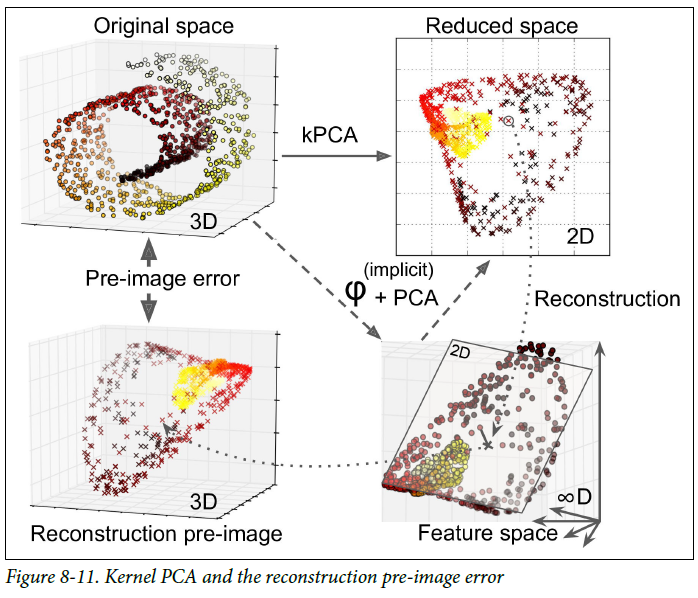

- You may be wondering how to perform this reconstruction. One solution is to train a
supervised regression model, with the projected instances as the training set and the
original instances as the targets.
- Scikit-Learn will do this automatically if you set
fit_inverse_transform=True, as shown in the following code

Note: By default, fit_inverse_transform=False and KernelPCA has no
inverse_transform() method. This method only gets created
when you set fit_inverse_transform=True.

In [199]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [200]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576615

- Now you can use grid search with cross-validation to find the kernel and hyperparameters
that minimize this **pre-image reconstruction error.**

## 8.5 LLE (Locally Linear Embedding)

- Locally Linear Embedding (LLE) is another very powerful nonlinear dimensionality
reduction (NLDR) technique.
- It is a **Manifold Learning** technique that does not rely
on **projections** like the previous algorithms.
- In a nutshell, LLE works by first measuring
how each training instance linearly relates to its closest neighbors (c.n.), and then
looking for a low-dimensional representation of the training set where these local
relationships are best preserved (more details shortly).
- This makes it particularly
good at unrolling twisted manifolds, especially **when there is not too much noise**

- For example, the following code uses Scikit-Learn’s LocallyLinearEmbedding class to
unroll the Swiss roll. The resulting 2D dataset is shown in Figure 8-12. As you can
see, the Swiss roll is completely unrolled and the distances between instances are
locally well preserved.
- However, distances are not preserved on a larger scale: the left
part of the unrolled Swiss roll is stretched, while the right part is squeezed. Nevertheless,
LLE did a pretty good job at modeling the manifold

In [201]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

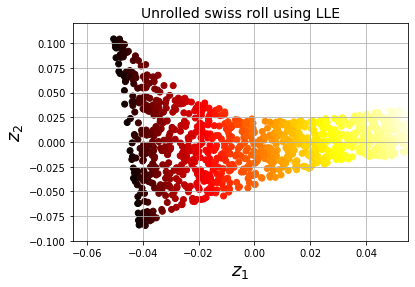

In [202]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)


plt.show()

## 8.6 Other Dimensionality Reduction Techniques

- **Multidimensional Scaling (MDS)** reduces dimensionality while trying to preserve
the distances between the instances
- **Isomap** creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the **geodesic distances** between the instances.
- **t-Distributed Stochastic Neighbor Embedding (t-SNE)** reduces dimensionality
while trying to keep similar instances close and dissimilar instances apart. It is
mostly used for visualization, in particular to visualize clusters of instances in
high-dimensional space (e.g., to visualize the MNIST images in 2D).
- **Linear Discriminant Analysis (LDA)** is actually a classification algorithm, but during
training it learns the most discriminative axes between the classes, and these
axes can then be used to define a hyperplane onto which to project the data. The
benefit is that the projection will keep classes as far apart as possible, so LDA is a **good technique to reduce dimensionality before running another classification
algorithm such as an SVM classifier.**

In [203]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [204]:

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [205]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [206]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

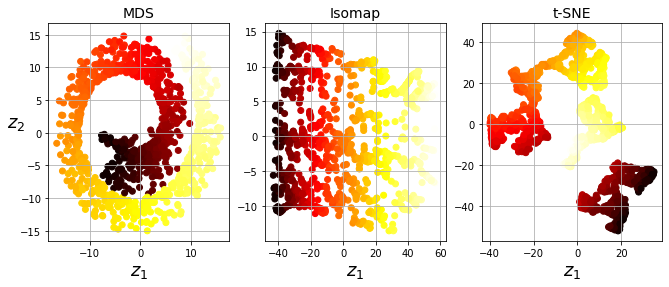

In [208]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

# EXERCISES

**1.** Load the MNIST dataset (introduced in Chapter 3) and split it into a training set
and a test set (take the first 60,000 instances for training, and the remaining
10,000 for testing). Train a Random Forest classifier on the dataset and time how
long it takes, then evaluate the resulting model on the test set. Next, use PCA to
reduce the dataset’s dimensionality, with an explained variance ratio of 95%.
Train a new Random Forest classifier on the reduced dataset and see how long it
takes. Was training much faster? Next evaluate the classifier on the test set: how
does it compare to the previous classifier?

**2.** Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the
result using Matplotlib. You can use a scatterplot using 10 different colors to represent
each image’s target class. Alternatively, you can write colored digits at the
location of each instance, or even plot scaled-down versions of the digit images
themselves (if you plot all digits, the visualization will be too cluttered, so you
should either draw a random sample or plot an instance only if no other instance
has already been plotted at a close distance). You should get a nice visualization
with well-separated clusters of digits. Try using other dimensionality reduction
algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

**Exercise 1 - Solution**

**Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).**

In [262]:
# prepare data

from sklearn.datasets import fetch_openml
np.random.seed(3)
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)


X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
X_test = X[-10000:]


y_train = y[:60000]
y_test = y[-10000:]

In [263]:
from sklearn.ensemble import RandomForestClassifier
import time

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [264]:
print('Training took {:.2f}s'.format(t1-t0))

Training took 41.29s


In [265]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

**Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.**

In [266]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

**Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?**

In [267]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf2.fit(X_reduced, y_train)
t1 = time.time()

In [268]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 90.09s


- Ops!!! Training is actaully more than twice slower now! How can that be after the dimensionality reduction?
- <span style='color:red'>**Dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm.** </span>
- If you try another model, it can change. Lets try softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA.
- We will do that after checking the accuracy of the new random forest classifier.

**Next evaluate the classifier on the test set: how does it compare to the previous classifier?**

In [269]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

- It is common for performance drop slightly when reducing dimensionality, because we do lose some useful signal in the process.
- However, the performance drop is rather severe in this case.
- So PCA really did not help: it slowed down tranining and reduced performance.

**Lets see if it helps when using softmax regression instead of random forest classifier.**
- Remember: softmax classifier is multinomial logistic regression. Since we have more than 1 target in MNIST (0,1,2,..9), we use multinomial logistic regression.

In [281]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,max_iter=100)


log_clf.fit(X_train,y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [283]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 5.82s


-  Let's train the softmax regression model using the reduced dataset and see how much PCA can help softmax regression.

In [284]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
log_clf2.fit(X_train_reduced, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [285]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

In [286]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 5.82s


- Nice! Reducing dimensionality led to a speedup.
- A very slight drop in performance, which might be a reasonable price to pay for a speedup, depending on the application.

<span style='color:red'>**So there you have it: PCA can give you a formidable speedup... but not always!**</span>

**Exercise 2 - Solution**

**2.** Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the
result using Matplotlib. You can use a scatterplot using 10 different colors to represent
each image’s target class. Alternatively, you can write colored digits at the
location of each instance, or even plot scaled-down versions of the digit images
themselves (if you plot all digits, the visualization will be too cluttered, so you
should either draw a random sample or plot an instance only if no other instance
has already been plotted at a close distance). You should get a nice visualization
with well-separated clusters of digits. Try using other dimensionality reduction
algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

**Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.**

- The MNIST dataset was loaded in previous question.
- Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [288]:
np.random.seed(42)

m = 10000

# get random permutation of 60000 indices then select the first 10000 indices
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [289]:
X.shape, y.shape

((10000, 784), (10000,))

In [290]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [291]:
# now the reduced dataset has only 2 features
X_reduced.shape

(10000, 2)

**Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit:**

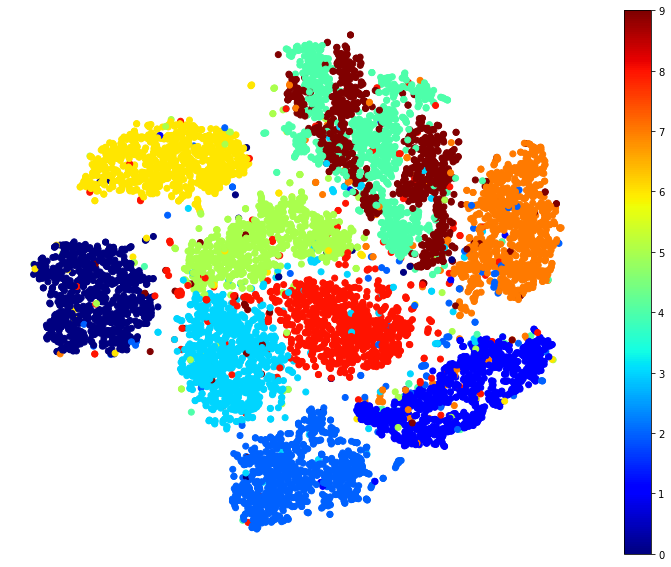

In [296]:
from matplotlib import cm

#plot x, do the coloring based on class (y)
plt.figure(figsize=(13,10))

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()

- This plot tells us which numbers are easily distinguishable from the others (e.g. 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g. 4s and 9s, 5s and 3s, and so on)
- Let's focus on digits 3 and 5, which seem to overlap a lot.

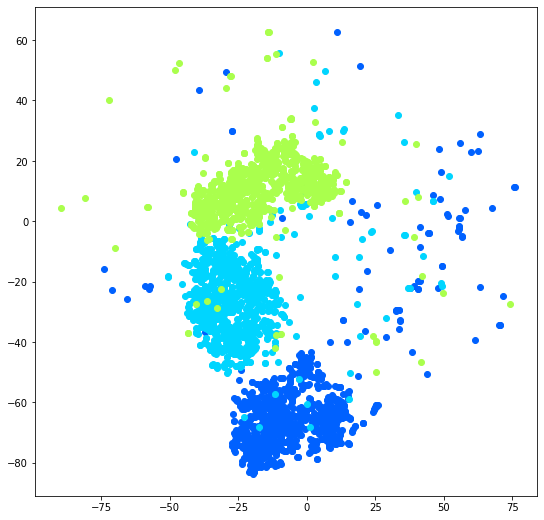

In [306]:
plt.figure(figsize=(9,9))

# A colormap is a callable that takes float values between 0. and 1. as input and returns a RGB color.
cmap = mpl.cm.get_cmap('jet')


# digit/9 is given as parameter to cmap to make the numbers float by diving the max number (9)
for digit in (2,3,5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit/9)])

- Let's see if we can produce a nicer image by running t-SNE on these 3 digits: (2, 3, 5)

In [308]:
idx = (y==2) | (y==3) | (y==5)

X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

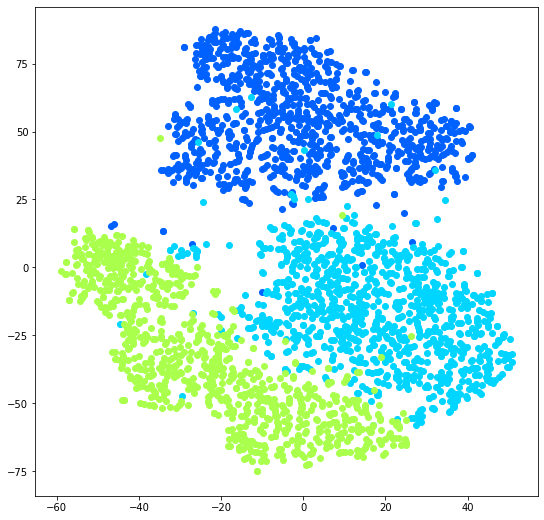

In [312]:
plt.figure(figsize=(9,9))
for digit in (2,3,5):
    plt.scatter(X_subset_reduced[y_subset==digit,0], X_subset_reduced[y_subset==digit,1], c=[cmap(digit/9)])

- Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

**Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.**

- Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead.

In [314]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    
    digits = np.unique(y) # from 0 to 9
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    
    
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

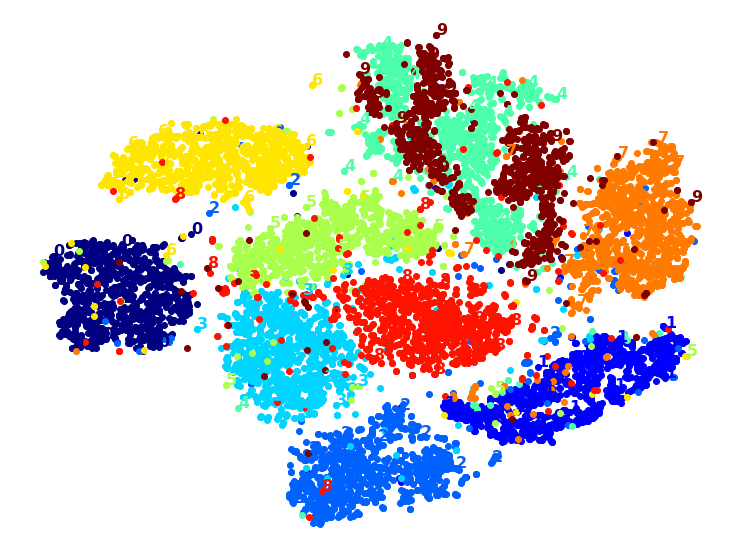

In [315]:
plot_digits(X_reduced, y)

- Well that's okay, but not that beautiful. Let's try with the digit images:

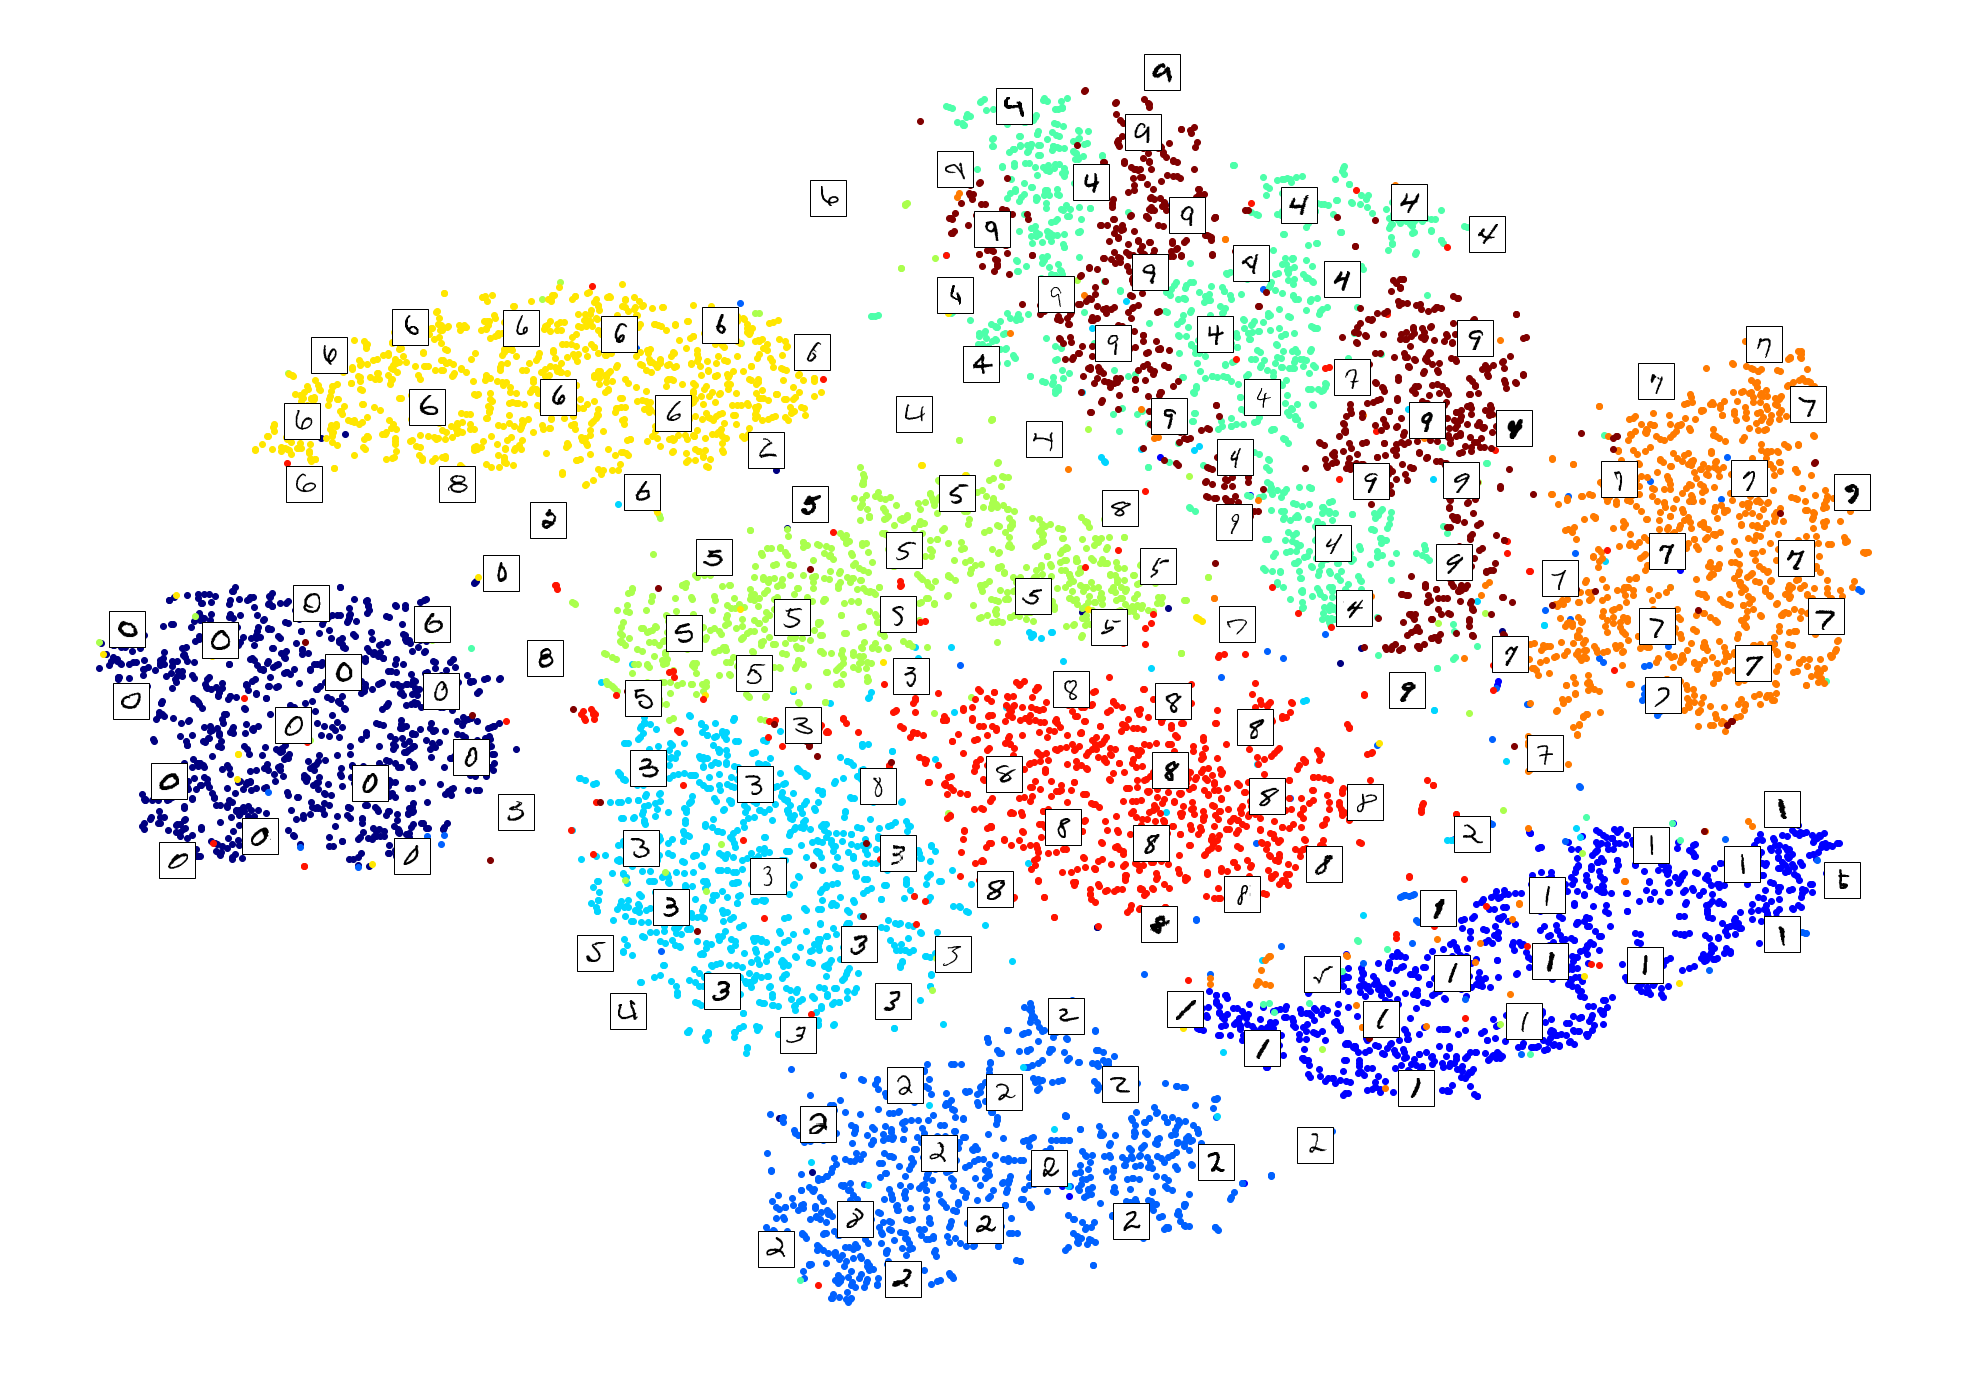

In [316]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

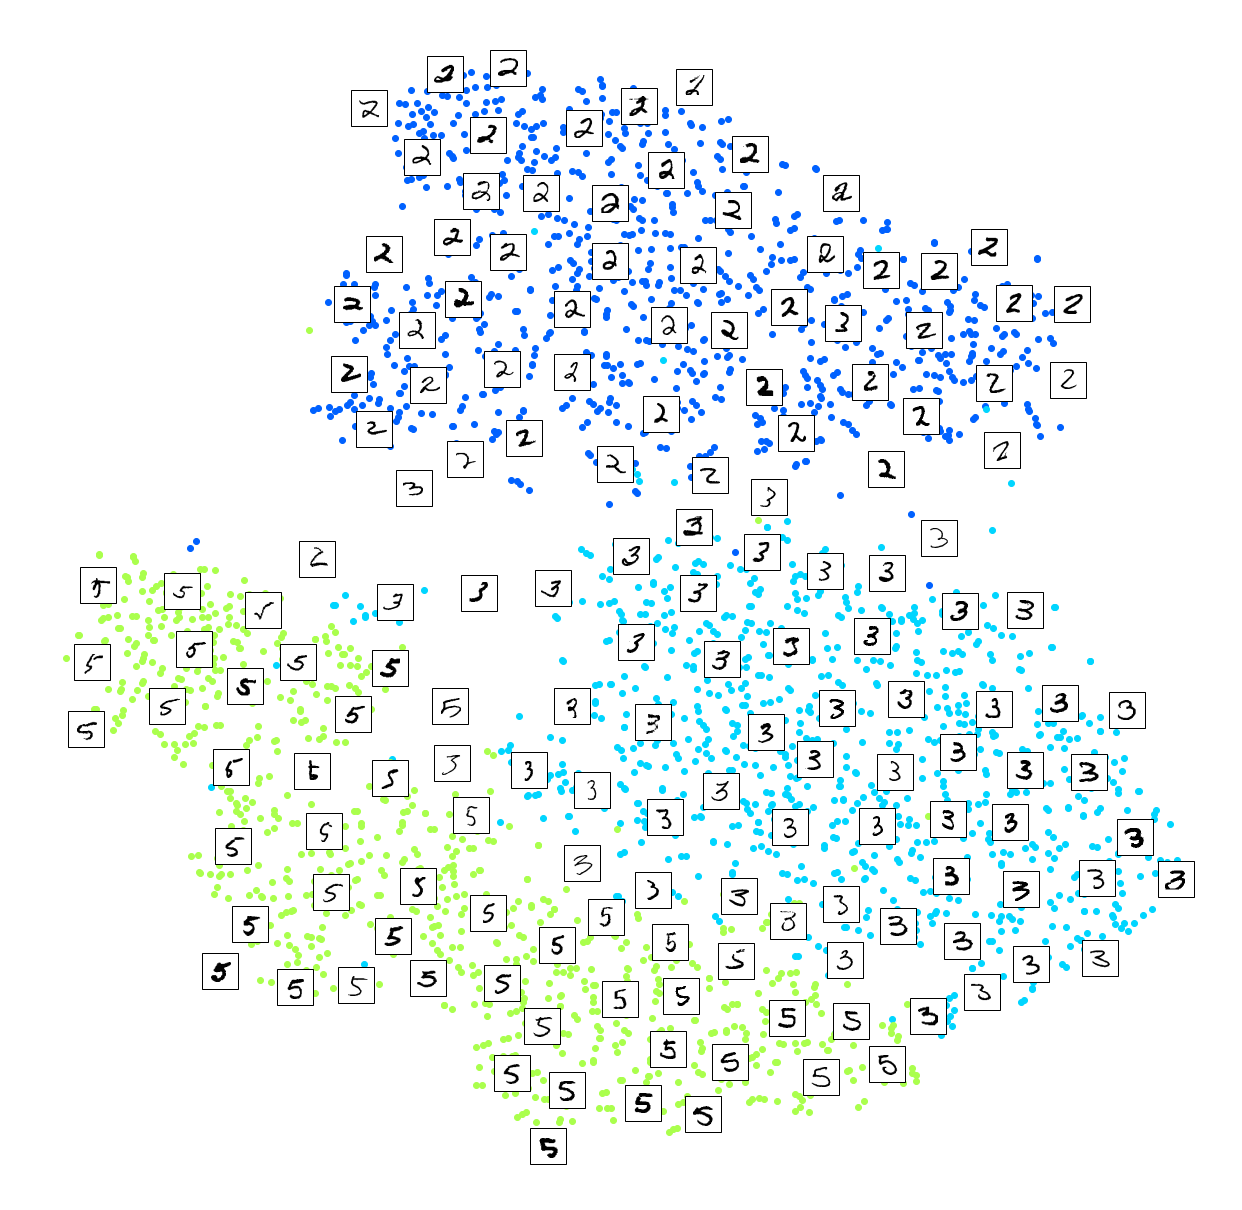

In [317]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

**Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.**
- Let's start with PCA. We will also time how long it takes:

PCA took 0.4s.


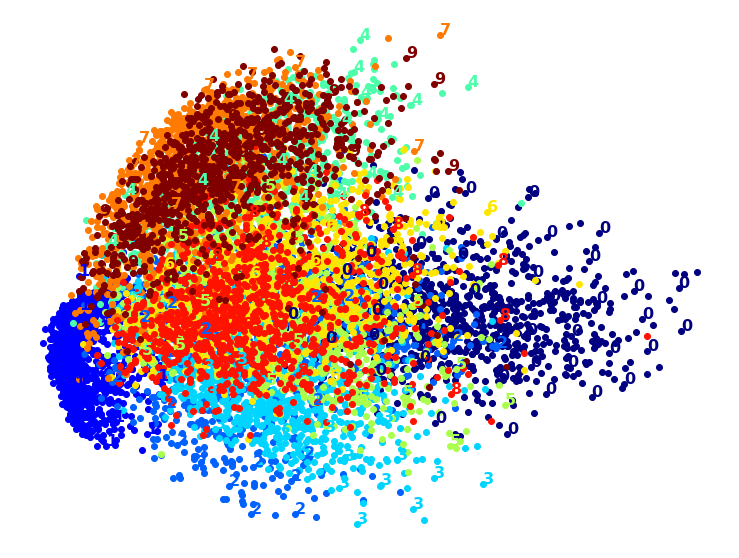

In [318]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

- Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap.
- Let's try LLE:

LLE took 130.4s.


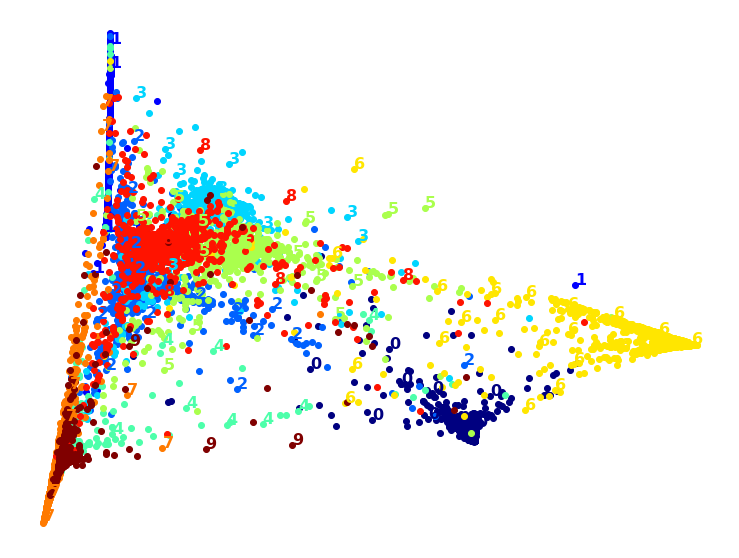

In [319]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

- That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 40.4s.


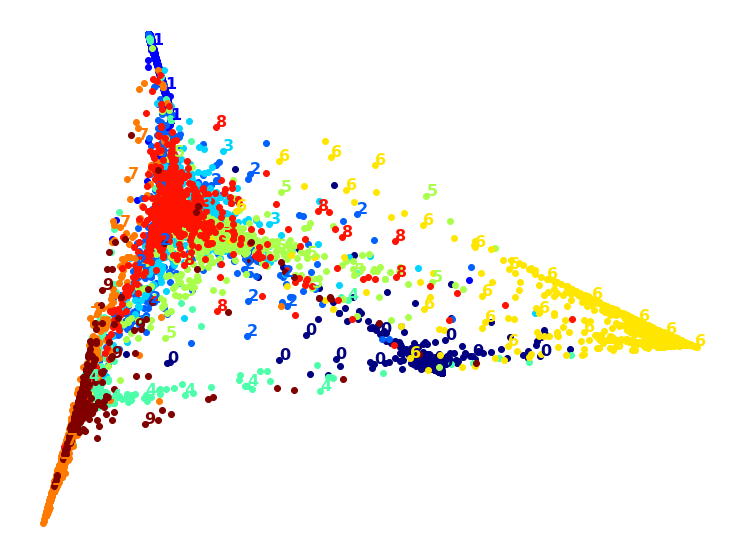

In [320]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

- The result is more or less the same, but this time it was almost 4× faster.
- Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 171.9s (on just 2,000 MNIST images instead of 10,000).


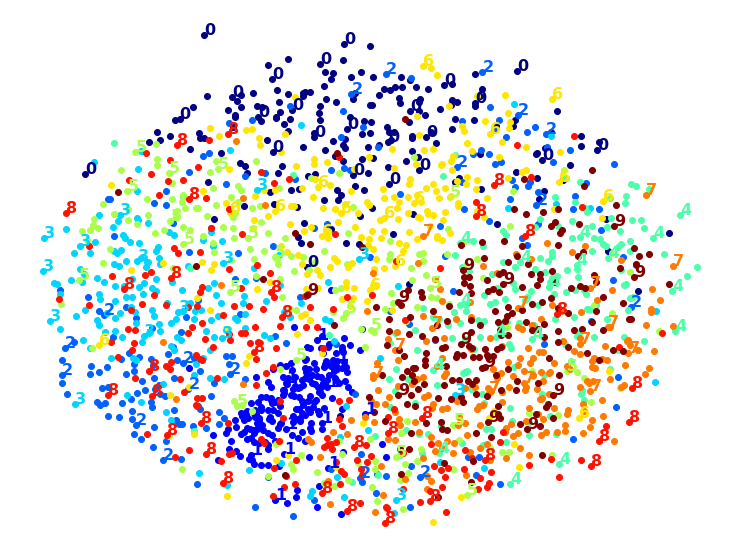

In [321]:

from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

- Meh. This does not look great, all clusters overlap too much. 
- Let's try with PCA first, perhaps it will be faster?

PCA+MDS took 165.8s (on 2,000 MNIST images).


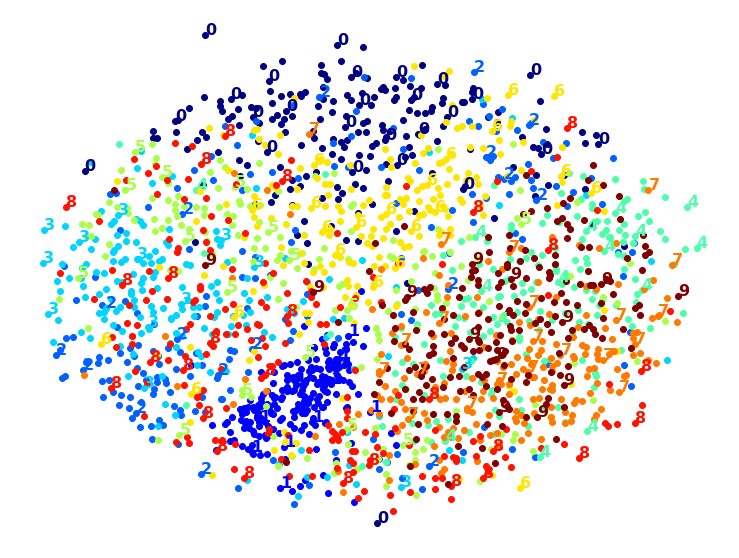

In [322]:

from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

- Same result, and no speedup: PCA did not help (or hurt).
- Let's try LDA:

LDA took 1.6s.


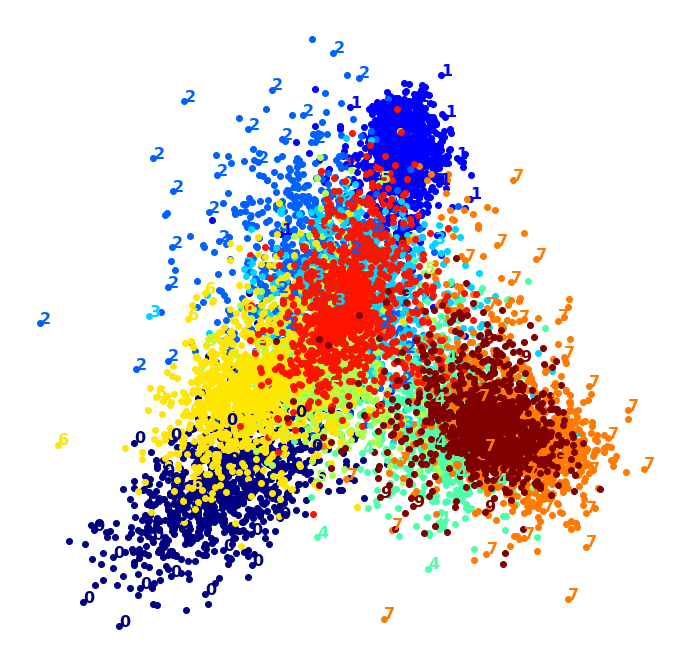

In [323]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

- This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.- This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

**RESULT**
- Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

t-SNE took 168.5s.


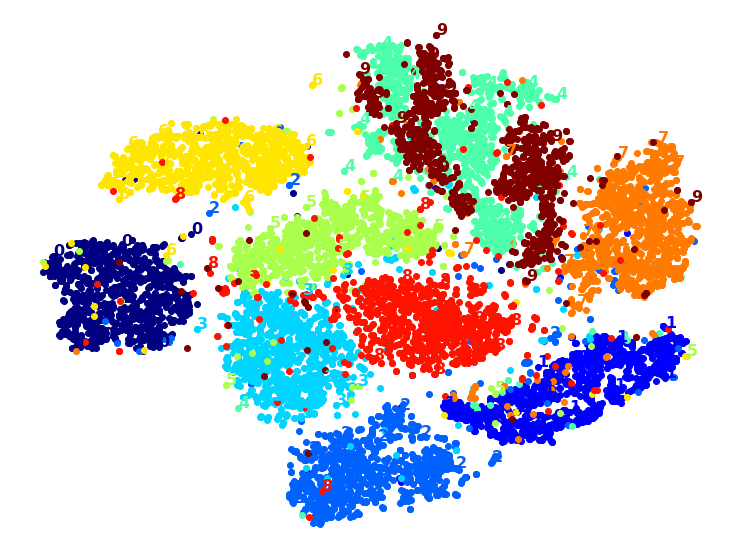

In [324]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

- It's twice slower than LLE, but still much faster than MDS, and the result looks great.
- Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 90.3s.


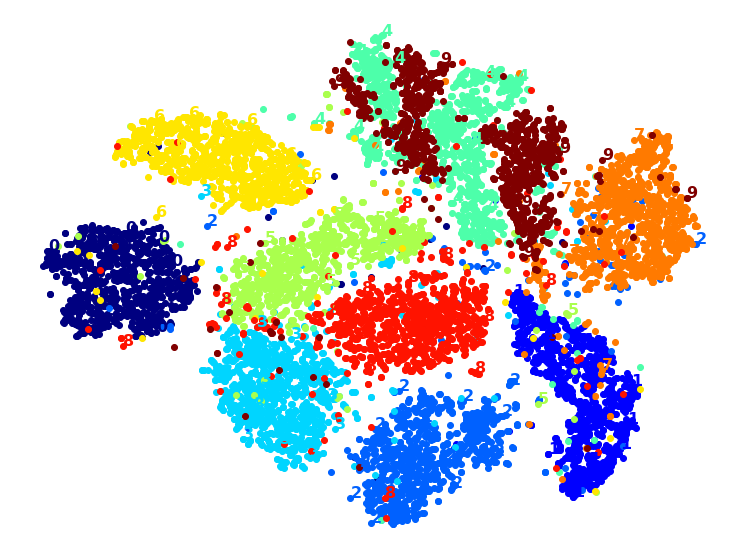

In [325]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

- Yes, PCA roughly gave us a 25% speedup, without damaging the result. We have a winner!